In [1]:
import warnings
warnings.filterwarnings('ignore')
from pandas import read_csv
import pandas as pd
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.signal import savgol_filter
import scipy.stats as stats
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy import fftpack

In [2]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [3]:
def error_metric(real,forecast):
    mse_val = mean_squared_error(real,forecast)
    rmse_val = sqrt(mse_val)
    mae_val = mean_absolute_error(real,forecast)
    return(mse_val,rmse_val,mae_val)

In [4]:
def prediccion_1(X, days_in_year, diferenced,P1,P2,P3,step):
    # fit model
    model = ARIMA(differenced, order=(P1,P2,P3))
    model_fit = model.fit()
    # multi-step out-of-sample forecast
    forecast = model_fit.forecast(steps=step)
    # invert the differenced forecast to something usable
    history = [x for x in X]
    day = 1
    predict = []
    for yhat in forecast:
        inverted = inverse_difference(history, yhat, days_in_year)
        predict.append(inverted)
        history.append(inverted)
        day += 1
    return predict

In [5]:
def resample_1(serie_to_predict):
    
    for i in range(1):
        #print(i)
        dividendo = (serie_to_predict[i+1]-serie_to_predict[i])/int(len(serie_to_predict)-1)
        if dividendo == 0:
            x1=[serie_to_predict[i]]
            range_1 = np.repeat(x1,10)
        else:
            range_1 = np.arange(serie_to_predict[i], serie_to_predict[i+1], dividendo).tolist()
    hall = []
    for i in range(int(len(serie_to_predict)-2)):
        #print(i)
        dividendo = (serie_to_predict[i+2] - serie_to_predict[i+1])/int(len(serie_to_predict)-1)
        if dividendo == 0:
            x1=[serie_to_predict[i+1]]
            range_2 = np.repeat(x1,10)
        else:
            range_2 = np.arange(serie_to_predict[i+1], serie_to_predict[i+2], dividendo).tolist()
        hall.append(range_2)        
    flat_list = [item for sublist in hall for item in sublist]
    total = range_1 + flat_list
    total.append(serie_to_predict[-1])
    window = 9
    total_1 = savgol_filter(total, window, 3) 
    return total_1

141


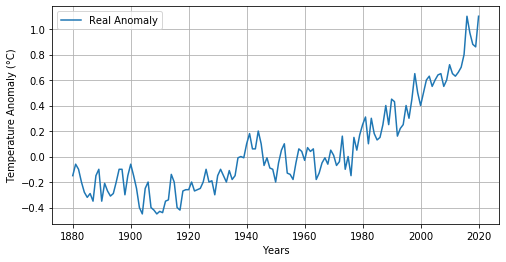

In [6]:
filename = "anomaly_data_1880_2020_goddard_150.csv"
goddard_series = pd.read_csv(filename)
goddard_series = goddard_series.dropna()['Goddard'] 
#======================================================
goddard_series = goddard_series.values
goddard_series = goddard_series[0:141]
fig, ax = plt.subplots(figsize=(8,4))
e=list(range(len(goddard_series)))
e = [x for x in e]
e = [x + 1880 for x in e]
ax.plot(e, goddard_series)
ax.set_xlabel('Years')
ax.set_ylabel('Temperature Anomaly (°C)');
ax.legend(['Real Anomaly'], loc='upper left')
ax.grid()
print(len(goddard_series))
#print(goddard_series)

In [7]:
goddard_series_resampled = []

for i in range(14):
    m = i*10
    #print(m)
    alpha = (i+1)*10
    #print(alpha+1)
    goddard_series_n = goddard_series[m:alpha+1]
    goddard_series_resampled_n = resample_1(goddard_series_n)
    goddard_series_resampled_n = goddard_series_resampled_n[:-1]
    goddard_series_resampled = np.append(goddard_series_resampled, goddard_series_resampled_n)
print(len(goddard_series_resampled))

1400


1400


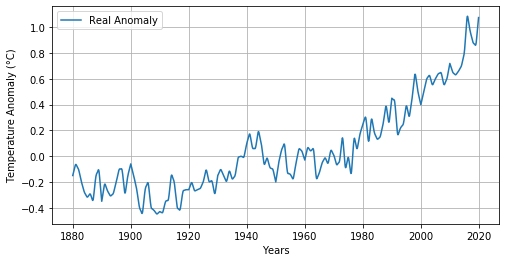

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
e=list(range(len(goddard_series_resampled)))
e = [x/10 for x in e]
e = [x + 1880 for x in e]
ax.plot(e, goddard_series_resampled)
ax.set_xlabel('Years')
ax.set_ylabel('Temperature Anomaly (°C)');
ax.legend(['Real Anomaly'], loc='upper left')
ax.grid()
#print(goddard_series_resampled)
print(len(goddard_series_resampled))

In [9]:
#np.savetxt('temperature anomaly resampled 1400.csv',goddard_series_resampled, delimiter=',', header=str('temperature'), comments="")

In [10]:
typical_procedure = goddard_series_resampled[0:1300]
days_in_year = 100
step = days_in_year
differenced = difference(typical_procedure, days_in_year)
anomaly_predicted_arima = prediccion_1(typical_procedure, days_in_year, differenced,2,1,3,step) # 2,1,3 excelente 1,1,3
anomaly_predicted_lstm = read_csv('anomaly_predicted_lstm.csv', header=0, index_col=0)
anomaly_predicted_stacked_lstm = read_csv('anomaly_predicted_stacked_lstm.csv', header=0, index_col=0)
anomaly_predicted_dense = read_csv('anomaly_predicted_dense.csv', header=0, index_col=0)

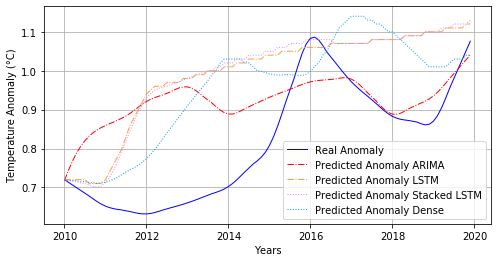

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
e=list(range(len(anomaly_predicted_lstm)))
e = [x /10 for x in e]
e = [x + (2010) for x in e]
#print(len(e))
ax.plot(e, goddard_series_resampled[1300:1400], linestyle='solid', color='blue', linewidth=1.0)
ax.plot(e, anomaly_predicted_arima, linestyle='dashdot', color='red', linewidth=1.0)
ax.plot(e, anomaly_predicted_lstm, linestyle='dashdot', color='#F9A048', linewidth=1.0)
ax.plot(e, anomaly_predicted_stacked_lstm, linestyle='dotted', color='violet', linewidth=1.0)
ax.plot(e, anomaly_predicted_dense, linestyle='dotted', color='#039dfc', linewidth=1.0)
ax.set_xlabel('Years')
ax.set_ylabel('Temperature Anomaly (°C)');
ax.grid()
plt.grid(True)
ax.legend(['Real Anomaly','Predicted Anomaly ARIMA','Predicted Anomaly LSTM','Predicted Anomaly Stacked LSTM','Predicted Anomaly Dense'], loc='lower right')

In [12]:
anomaly_predicted_lstm = read_csv('anomaly_predicted_lstm.csv', header=0, index_col=0)
anomaly_predicted_lstm = anomaly_predicted_lstm.dropna()['temperature'] 
anomaly_predicted_lstm = anomaly_predicted_lstm.values

anomaly_predicted_stacked_lstm = read_csv('anomaly_predicted_stacked_lstm.csv', header=0, index_col=0)
anomaly_predicted_stacked_lstm = anomaly_predicted_stacked_lstm.dropna()['temperature'] 
anomaly_predicted_stacked_lstm = anomaly_predicted_stacked_lstm.values

anomaly_predicted_dense = read_csv('anomaly_predicted_dense.csv', header=0, index_col=0)
anomaly_predicted_dense = anomaly_predicted_dense.dropna()['temperature'] 
anomaly_predicted_dense = anomaly_predicted_dense.values

In [13]:
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], anomaly_predicted_arima)
print('Goddard dataset vs ARIMA Prediction, Correlation coefficient: ',r1)
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], anomaly_predicted_lstm)
print('Goddard dataset vs LSTM Prediction, Correlation coefficient: ',r1)
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], anomaly_predicted_stacked_lstm)
print('Goddard dataset vs Stacked LSTM, Correlation coefficient: ',r1)
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], anomaly_predicted_dense)
print('Goddard dataset vs Dense Prediction, Correlation coefficient: ',r1)

Goddard dataset vs ARIMA Prediction, Correlation coefficient:  0.5968586917596833
Goddard dataset vs LSTM Prediction, Correlation coefficient:  0.6818733746457067
Goddard dataset vs Stacked LSTM, Correlation coefficient:  0.6960090295766259
Goddard dataset vs Dense Prediction, Correlation coefficient:  0.7244121182297562


In [14]:
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], anomaly_predicted_arima)
print('Goddard dataset vs ARIMA Prediction, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], anomaly_predicted_lstm)
print('Goddard dataset vs LSTM Prediction, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], anomaly_predicted_stacked_lstm)
print('Goddard dataset vs Stacked LSTM, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], anomaly_predicted_dense)
print('Goddard dataset vs Dense Prediction, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)

Goddard dataset vs ARIMA Prediction, MSE:  0.026848406718943275 RMSE:  0.16385483428615488 MAE:  0.1267535068363461
Goddard dataset vs LSTM Prediction, MSE:  0.04330610155431906 RMSE:  0.2081011810497938 MAE:  0.17785757575757669
Goddard dataset vs Stacked LSTM, MSE:  0.043871176402803934 RMSE:  0.20945447334159262 MAE:  0.17878004329004427
Goddard dataset vs Dense Prediction, MSE:  0.030621330082457522 RMSE:  0.17498951420715905 MAE:  0.14797000000000085


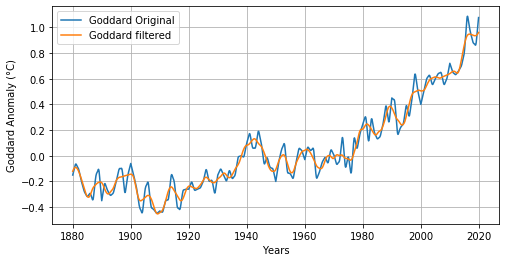

In [15]:
window = 71 # window size 71, polynomial order 3 (bien), window size 81, polynomial order 3 (el mejor)
goddard_series_resampled_filtered = savgol_filter(goddard_series_resampled, window, 3) 
fig, ax = plt.subplots(figsize=(8,4))
e=list(range(len(goddard_series_resampled_filtered)))
e = [x /10 for x in e]
e = [x + (1880) for x in e]
ax.plot(e, goddard_series_resampled)
ax.plot(e, goddard_series_resampled_filtered)
ax.set_xlabel('Years')
ax.set_ylabel('Goddard Anomaly (°C)');
ax.grid()
plt.legend(['Goddard Original','Goddard filtered'], loc='upper left')
plt.grid(True)

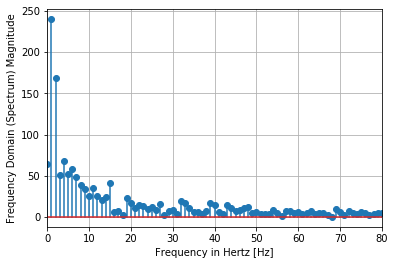

In [16]:
f_s = len(goddard_series_resampled)
f = f_s/10
t=list(range(len(goddard_series_resampled)))
x = goddard_series_resampled
X_1 = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * f_s
fig, ax = plt.subplots()
ax.stem(freqs, np.abs(X_1))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 80)
ax.grid()

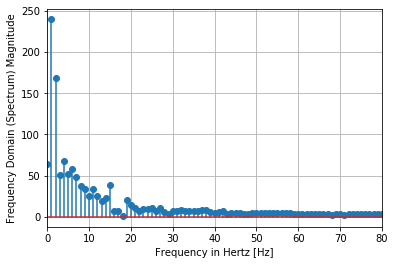

In [17]:
x = goddard_series_resampled_filtered
X_2 = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * f_s
fig, ax = plt.subplots()
ax.stem(freqs, np.abs(X_2))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 80)
ax.grid()

1400


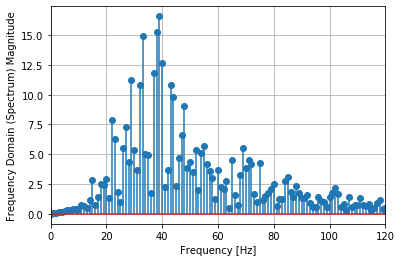

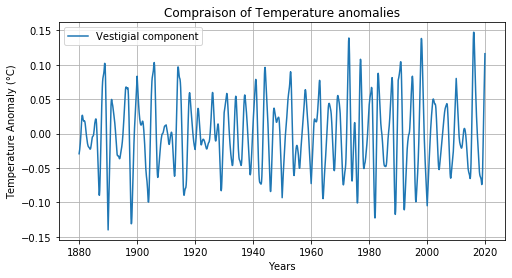

In [18]:
freq_component = X_1 - X_2
fig, ax = plt.subplots()
ax.stem(freqs, np.abs(freq_component))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 120)
#ax.set_ylim(-5, 110)
ax.grid()
vestigial_component = fftpack.ifft(freq_component)
plt.figure(figsize=(8,4))
plt.title('Compraison of Temperature anomalies')
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (°C)')
plt.plot(e, vestigial_component, label='Hadley')
plt.grid(True)
plt.legend(['Vestigial component'], loc='upper left')
print(len(vestigial_component))

In [19]:
#np.savetxt('vestigial_component_anomaly_temperature.csv', vestigial_component.real, delimiter=',', header=str('value'), comments="")

100


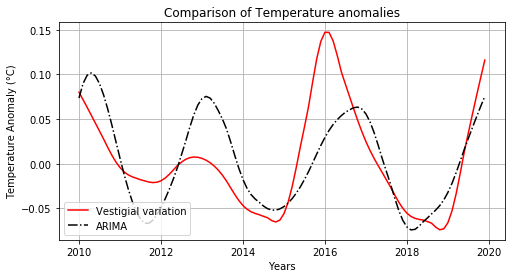

In [20]:
vestigial_real = vestigial_component[0:1300]
days_in_year = 100
step = days_in_year
differenced = difference(vestigial_real.real, days_in_year)
vestigial_real_predicted=prediccion_1(vestigial_real.real, days_in_year, differenced,3,0,1,step) #3,0,1
e=list(range(len(vestigial_real_predicted)))
e = [x /10 for x in e]
e = [x + (2010) for x in e]
plt.figure(figsize=(8,4))
plt.title('Comparison of Temperature anomalies')
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (°C)')
plt.plot(e, vestigial_component[1300:1400], linestyle='solid', color='red')
plt.plot(e, vestigial_real_predicted, linestyle='dashdot', color='black')
plt.grid(True)
plt.legend(['Vestigial variation','ARIMA'], loc='lower left')
print(len(vestigial_real_predicted))

100


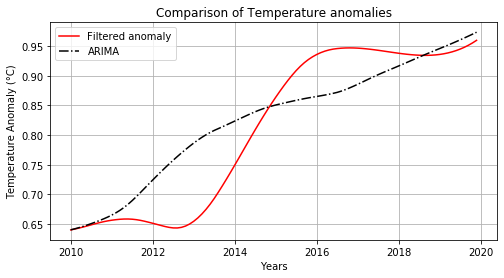

In [21]:
filtered_real = goddard_series_resampled_filtered[0:1300]
days_in_year = 100
step = days_in_year
differenced = difference(filtered_real.real, days_in_year)
filtered_real_predicted=prediccion_1(filtered_real.real, days_in_year, differenced,4,1,3,step) # window 71. 4,1,3, # window 81. 4,2,1
e=list(range(len(filtered_real_predicted)))
e = [x /10 for x in e]
e = [x + (2010) for x in e]
plt.figure(figsize=(8,4))
plt.title('Comparison of Temperature anomalies')
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (°C)')
plt.plot(e, goddard_series_resampled_filtered[1300:1400], linestyle='solid', color='red')
plt.plot(e, filtered_real_predicted, linestyle='dashdot', color='black')
plt.grid(True)
plt.legend(['Filtered anomaly','ARIMA'], loc='upper left')
print(len(filtered_real_predicted))

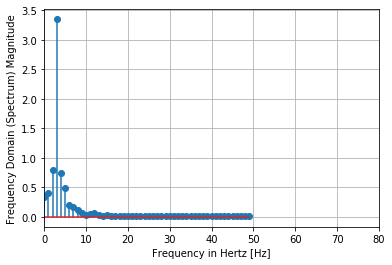

In [22]:
f_s = len(vestigial_real_predicted)
f = f_s/10
x1 = vestigial_real_predicted
X_1 = fftpack.fft(x1)
freqs = fftpack.fftfreq(len(x1)) * f_s
fig, ax = plt.subplots()
ax.stem(freqs, np.abs(X_1))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 80)
#ax.set_ylim(-5, 110)
ax.grid()

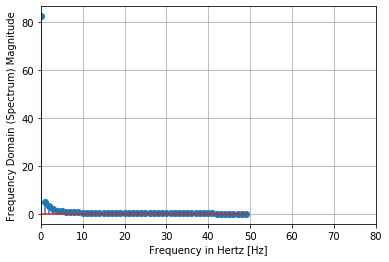

In [23]:
x2 = filtered_real_predicted
X_2 = fftpack.fft(x2)
freqs = fftpack.fftfreq(len(x2)) * f_s
fig, ax = plt.subplots()
ax.stem(freqs, np.abs(X_2))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 80)
#ax.set_ylim(-5, 110)
ax.grid()

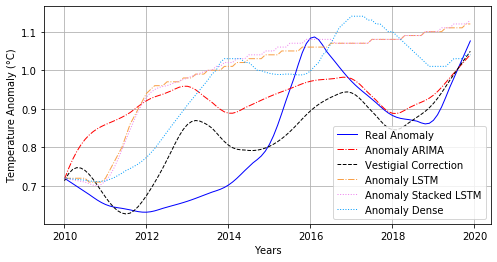

In [24]:
unified = fftpack.ifft(X_1 + X_2)
fig, ax = plt.subplots(figsize=(8,4))
e=list(range(len(unified.real)))
e = [x /10 for x in e]
e = [x + (2010) for x in e]
ax.plot(e, goddard_series_resampled[1300:1400], linestyle='solid', color='blue', linewidth=1.0)
ax.plot(e, anomaly_predicted_arima, linestyle='dashdot', color='red', linewidth=1.0)
ax.plot(e, unified, linestyle='dashed', color='black', linewidth=1.0)
ax.plot(e, anomaly_predicted_lstm, linestyle='dashdot', color='#F9A048', linewidth=1.0)
ax.plot(e, anomaly_predicted_stacked_lstm, linestyle='dotted', color='violet', linewidth=1.0)
ax.plot(e, anomaly_predicted_dense, linestyle='dotted', color='#039dfc', linewidth=1.0)
ax.set_xlabel('Years')
ax.set_ylabel('Temperature Anomaly (°C)');
ax.grid()
plt.grid(True)
ax.legend(['Real Anomaly','Anomaly ARIMA','Vestigial Correction','Anomaly LSTM','Anomaly Stacked LSTM','Anomaly Dense'], loc='lower right')


In [25]:
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], anomaly_predicted_lstm)
print('Goddard dataset vs LSTM Prediction, Correlation coefficient: ',r1)
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], anomaly_predicted_stacked_lstm)
print('Goddard dataset vs Stacked LSTM, Correlation coefficient: ',r1)
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], anomaly_predicted_dense)
print('Goddard dataset vs Dense Prediction, Correlation coefficient: ',r1)
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], anomaly_predicted_arima)
print('Goddard dataset vs ARIMA Prediction, Correlation coefficient: ',r1)
r1, p1 = stats.pearsonr(goddard_series_resampled[1300:1400], unified.real)
print('Goddard dataset vs Unified Prediction, Correlation coefficient: ',r1)

Goddard dataset vs LSTM Prediction, Correlation coefficient:  0.6818733746457067
Goddard dataset vs Stacked LSTM, Correlation coefficient:  0.6960090295766259
Goddard dataset vs Dense Prediction, Correlation coefficient:  0.7244121182297562
Goddard dataset vs ARIMA Prediction, Correlation coefficient:  0.5968586917596833
Goddard dataset vs Unified Prediction, Correlation coefficient:  0.8055283330136241


In [26]:
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], anomaly_predicted_lstm)
print('Goddard dataset vs LSTM Prediction, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], anomaly_predicted_stacked_lstm)
print('Goddard dataset vs Stacked LSTM, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], anomaly_predicted_dense)
print('Goddard dataset vs Dense Prediction, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], anomaly_predicted_arima)
print('Goddard dataset vs Simple Prediction, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)
mse,rmse,mae=error_metric(goddard_series_resampled[1300:1400], unified.real)
print('Goddard dataset vs Unified Prediction, MSE: ',mse,'RMSE: ',rmse,'MAE: ',mae)

Goddard dataset vs LSTM Prediction, MSE:  0.04330610155431906 RMSE:  0.2081011810497938 MAE:  0.17785757575757669
Goddard dataset vs Stacked LSTM, MSE:  0.043871176402803934 RMSE:  0.20945447334159262 MAE:  0.17878004329004427
Goddard dataset vs Dense Prediction, MSE:  0.030621330082457522 RMSE:  0.17498951420715905 MAE:  0.14797000000000085
Goddard dataset vs Simple Prediction, MSE:  0.026848406718943275 RMSE:  0.16385483428615488 MAE:  0.1267535068363461
Goddard dataset vs Unified Prediction, MSE:  0.008360652043410079 RMSE:  0.09143660122407263 MAE:  0.06808789624071368


100


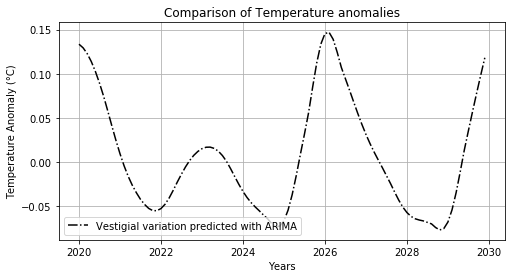

In [27]:
vestigial_real = vestigial_component[0:1400]
days_in_year = 100
step = days_in_year
differenced = difference(vestigial_real.real, days_in_year)
vestigial_real_predicted=prediccion_1(vestigial_real.real, days_in_year, differenced,3,0,1,step) # excelente #2,2,2
e=list(range(len(vestigial_real_predicted)))
e = [x /10 for x in e]
e = [x + (2020) for x in e]
plt.figure(figsize=(8,4))
plt.title('Comparison of Temperature anomalies')
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (°C)')
#plt.plot(e, vestigial_component[1300:1400], linestyle='solid', color='red')
plt.plot(e, vestigial_real_predicted, linestyle='dashdot', color='black')
plt.grid(True)
plt.legend(['Vestigial variation predicted with ARIMA'], loc='lower left')
print(len(vestigial_real_predicted))

100


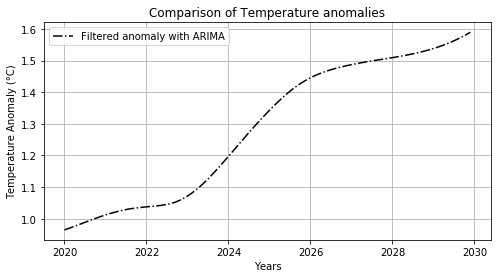

In [28]:
filtered_real = goddard_series_resampled_filtered[0:1400]
days_in_year = 100
step = days_in_year
differenced = difference(filtered_real.real, days_in_year)
filtered_real_predicted=prediccion_1(filtered_real.real, days_in_year, differenced,4,1,3,step) # excelente #1,1,1
e=list(range(len(filtered_real_predicted)))
e = [x /10 for x in e]
e = [x + (2020) for x in e]
plt.figure(figsize=(8,4))
plt.title('Comparison of Temperature anomalies')
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (°C)')
#plt.plot(e, goddard_series_resampled_filtered[1300:1400], linestyle='solid', color='red')
plt.plot(e, filtered_real_predicted, linestyle='dashdot', color='black')
plt.grid(True)
plt.legend(['Filtered anomaly with ARIMA'], loc='upper left')
print(len(filtered_real_predicted))

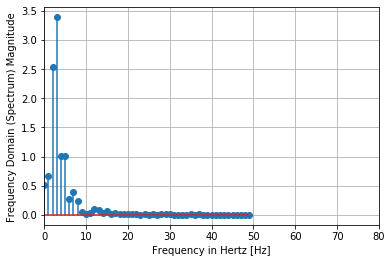

In [29]:
f_s = 100
f = f_s/10
x1 = vestigial_real_predicted
X_1 = fftpack.fft(x1)
freqs = fftpack.fftfreq(len(x1)) * f_s
fig, ax = plt.subplots()
ax.stem(freqs, np.abs(X_1))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 80)
#ax.set_ylim(-5, 110)
ax.grid()

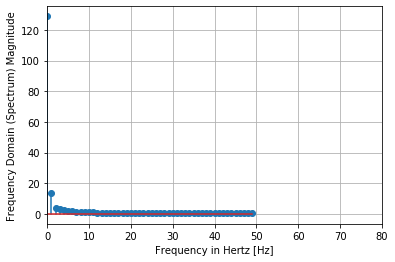

In [30]:
x2 = filtered_real_predicted
X_2 = fftpack.fft(x2)
freqs = fftpack.fftfreq(len(x2)) * f_s
fig, ax = plt.subplots()
ax.stem(freqs, np.abs(X_2))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 80)
#ax.set_ylim(-5, 110)
ax.grid()

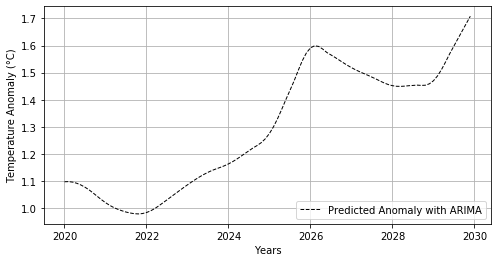

In [31]:
unified = fftpack.ifft(X_1 + X_2)
fig, ax = plt.subplots(figsize=(8,4))
e=list(range(len(unified.real)))
e = [x /10 for x in e]
e = [x + (2020) for x in e]
ax.plot(e, unified, linestyle='dashed', color='black', linewidth=1.0)
ax.set_xlabel('Years')
ax.set_ylabel('Temperature Anomaly (°C)');
ax.grid()
plt.grid(True)
ax.legend(['Predicted Anomaly with ARIMA'], loc='lower right')

1500


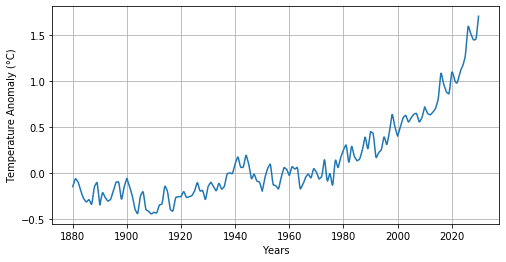

In [32]:
fig, ax = plt.subplots(figsize=(8,4))
uni_tot = np.concatenate((goddard_series_resampled,unified.real))
e=list(range(len(uni_tot)))
e = [x /10 for x in e]
e = [x + (1880) for x in e]
#ax.plot(e, serie_1_upsampled[1300:1400])
ax.plot(e, uni_tot)
#ax.plot(e, uni_tot, linestyle='dashed', color='red')
ax.set_xlabel('Years')
ax.set_ylabel('Temperature Anomaly (°C)');
ax.grid()
plt.grid(True)
print(len(uni_tot))

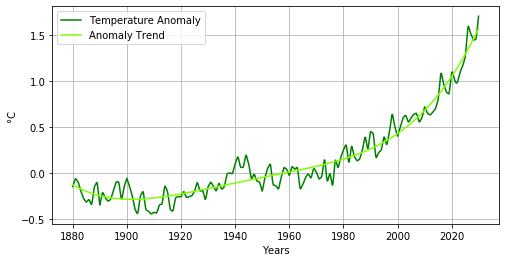

           4             3          2
2.343e-08 x - 0.0001822 x + 0.5314 x - 688.7 x + 3.347e+05


In [37]:
modela1 = np.poly1d(np.polyfit(e, uni_tot.real, 1))
modela2 = np.poly1d(np.polyfit(e, uni_tot.real, 2))
modela3 = np.poly1d(np.polyfit(e, uni_tot.real, 3))
modela4 = np.poly1d(np.polyfit(e, uni_tot.real, 4))
modela5 = np.poly1d(np.polyfit(e, uni_tot.real, 5))
modela6 = np.poly1d(np.polyfit(e, uni_tot.real, 6))
#modela7 = np.poly1d(np.polyfit(e, uni_tot.real, 7)) #the equation doesn't represent the trend
#modela8 = np.poly1d(np.polyfit(e, uni_tot.real, 8))
#modela9 = np.poly1d(np.polyfit(e, uni_tot.real, 9))
#modela10 = np.poly1d(np.polyfit(e, uni_tot.real, 10))
#create scatterplot
plt.subplots(figsize=(8,4))


#plt.plot(e, uni_tot, linestyle='dashed', color='red')
plt.plot(e, uni_tot, linestyle='solid', color='green')
plt.plot(e, modela4(e), color='#7FFF00')

#plt.plot(e, modela5(e), linestyle='dashed', color='green')
plt.xlabel('Years')
plt.ylabel('°C')
plt.grid(True)
plt.legend(['Temperature Anomaly','Anomaly Trend'], loc='upper left')
plt.show()
print(modela4)

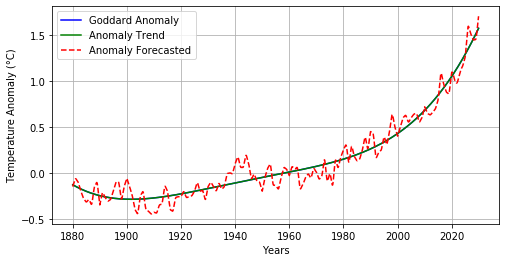

           4             3          2
2.343e-08 x - 0.0001822 x + 0.5314 x - 688.7 x + 3.347e+05


In [34]:
plt.subplots(figsize=(8,4))
plt.plot(e, modela4(e), color='blue')
plt.plot(e, modela4(e), color='green')
plt.plot(e, uni_tot, linestyle='dashed', color='red')
#plt.plot(e, modela5(e), linestyle='dashed', color='green')
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (°C)')
plt.grid(True)
plt.legend(['Goddard Anomaly','Anomaly Trend','Anomaly Forecasted'], loc='upper left')
plt.show()
print(modela4)

In [35]:
window_size = ['11', '21', '31', '41', '51', '61', '71', '81', '91']
MSE_result = [0.020652325911633077, 0.01936691104462037, 0.014937303930546814, 0.03270146253310546, 0.16025780185194274, 0.056597049105454406, 0.008360652043410079, 0.027247405218625276, 0.11675928524328887]
RMSE_result = [0.14370917128573624, 0.13916504965191645, 0.12221826349014624, 0.18083545706831242, 0.40032212261120764, 0.23790134321910503, 0.09143660122407263, 0.16506788063892164, 0.3417005783478993]
MAE_result = [0.11278454117617287, 0.10983057697167217, 0.10695422697759675, 0.13771114456033196, 0.365727075858638, 0.2119711641038097, 0.06808789624071368, 0.13846201278438752, 0.27209303629188064]
Correlation_coeff = [0.5956155616172802, 0.5898581786001358, 0.6811891875924149, 0.6546418488135336, 0.8175867413655594, 0.8332989299401352, 0.8055283330136241, 0.32172894466931146, -0.4451995894815513]


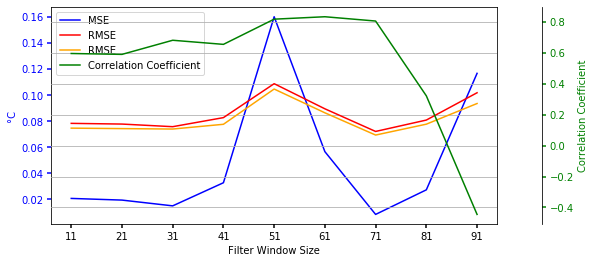

In [36]:
import matplotlib.pyplot as plt
plt.ioff()

def adjust_extra_yaxes(ax, pct_shift):
    ax.spines["right"].set_position(("axes", 1+pct_shift))
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.spines["right"].set_visible(True)

fig, ax_0 = plt.subplots(figsize=(8,4))

ax_1 = ax_0.twinx()
#ax_2 = ax_0.twinx()

num_extra_yaxes = 1

pct_width_per_yaxis = 0.1
fig_right_margin = 1.0 - pct_width_per_yaxis*num_extra_yaxes
fig.subplots_adjust(right=fig_right_margin)

i = 1
for ax in [ax_1]:
    adjust_extra_yaxes(ax, pct_width_per_yaxis*i)
    i+=1

l0, = ax_0.plot(window_size, MSE_result, linestyle='-', label="MSE", color='Blue')
l1, = ax_1.plot(window_size, RMSE_result, linestyle='-', label="RMSE", color='red')
l2, = ax_1.plot(window_size, MAE_result, linestyle='-', label="RMSE", color='orange')
l3, = ax_1.plot(window_size, Correlation_coeff, linestyle='-', label="Correlation Coefficient", color='green')

ax_0.yaxis.label.set_color(l0.get_color())
ax_1.yaxis.label.set_color(l1.get_color())
ax_1.yaxis.label.set_color(l2.get_color())
ax_1.yaxis.label.set_color(l3.get_color())

ax_0.set_xlabel("Filter Window Size")
ax_0.set_ylabel("°C")
ax_1.set_ylabel("Correlation Coefficient")


tkw = dict(size=4, width=1.5)
ax_0.tick_params(axis='y', colors=l0.get_color(), **tkw)
ax_1.tick_params(axis='y', colors=l1.get_color(), **tkw)
ax_1.tick_params(axis='y', colors=l2.get_color(), **tkw)
ax_1.tick_params(axis='y', colors=l3.get_color(), **tkw)
ax_0.tick_params(axis='x', **tkw)

lines = [l0, l1, l2, l3]
ax_0.legend(lines, [l.get_label() for l in lines])
plt.grid(True)
plt.show()